In [1]:

import pandas as pd 
import os 
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from scipy.stats import mannwhitneyu, normaltest
# import statsmodels.stats.multitest as sm
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test



C:\Users\jhroe\AppData\Local\Temp\ipykernel_18188\3591221630.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# date = datetime.now().strftime("%Y%m%d")

# Get current directory
path = os.getcwd()
data_path = path + '/Data/'

pi = pd.read_excel(f'{data_path}/raw/LUAD Clinical Data.xlsx')
pi.rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=True)

# Set path 
df = pd.read_csv(f"{data_path}/clustering/full_cd_clus_19_39_48.csv").rename(columns={'cluster': 'agglomerateto_275'}).rename(columns={'agglomerateto_39':'cluster'})
df_loc = pd.read_csv(f"{data_path}/celldata/celldata_20240506.csv")[['cellID', 'Location_Center_X', 'Location_Center_Y']].rename(columns={'cellID': 'source_ID'})

# Merge location data 
df= pd.merge(df, df_loc, on='source_ID', how='inner').rename(columns={'agglomerateto_39':'cluster'})


In [3]:
data = df[['Patient_ID', 'cluster']]
count_data = data.groupby(['Patient_ID', 'cluster']).size().reset_index(name='count')
total_clus = count_data.groupby(['Patient_ID'])['count'].sum().reset_index(name='total_clus')
count_df = pd.merge(count_data, total_clus, on=['Patient_ID'])

count_df['relative_frequency'] = (count_df['count'] / count_df['total_clus'])
count_df
# count_data

,Patient_ID,cluster,count,total_clus,relative_frequency
0,LUAD_D001,1,56,4517,0.012398
1,LUAD_D001,2,3,4517,0.000664
2,LUAD_D001,3,12,4517,0.002657
3,LUAD_D001,4,198,4517,0.043834
4,LUAD_D001,5,1378,4517,0.305070
...,...,...,...,...,...
12877,LUAD_D416,35,11,2879,0.003821
12878,LUAD_D416,36,7,2879,0.002431
12879,LUAD_D416,37,13,2879,0.004515
12880,LUAD_D416,38,10,2879,0.003473


In [5]:
pi.columns

Index(['Patient_ID', 'Sex (Male: 0, Female: 1)', 'Age (<75: 0, ≥75: 1)',
       'BMI (<30: 0, ≥30: 1)', 'Smoking Status (Smoker: 0, Non-smoker:1)',
       'Pack Years (1-30: 0, ≥30: 1)', 'Stage (I-II: 0, III-IV:1)',
       'Progression (No: 0, Yes: 1) ', 'death', 'survival',
       'Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)'],
      dtype='object')

In [6]:
df_plots = pd.merge(df, pi, on='Patient_ID', how='inner')

df_plots = df_plots[df_plots['cluster'].isin([26,27])][['cluster', 'source_cluster','Patient_ID', 'Sex (Male: 0, Female: 1)', 'Age (<75: 0, ≥75: 1)',
       'BMI (<30: 0, ≥30: 1)', 'Smoking Status (Smoker: 0, Non-smoker:1)',
       'Pack Years (1-30: 0, ≥30: 1)', 'Stage (I-II: 0, III-IV:1)',
       'Progression (No: 0, Yes: 1) ', 'death', 'survival',
       'Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)']]
df_plots

,cluster,source_cluster,Patient_ID,"Sex (Male: 0, Female: 1)","Age (<75: 0, ≥75: 1)","BMI (<30: 0, ≥30: 1)","Smoking Status (Smoker: 0, Non-smoker:1)","Pack Years (1-30: 0, ≥30: 1)","Stage (I-II: 0, III-IV:1)","Progression (No: 0, Yes: 1)",death,survival,"Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)"
0,27,Cancer,LUAD_D001,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
4,27,Treg,LUAD_D001,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
5,26,B,LUAD_D001,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
8,26,Tc,LUAD_D001,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
15,27,Unknown,LUAD_D001,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637709,27,Endothelial,LUAD_D416,1,0,1,0.0,1.0,0.0,0.0,0,9.386,3
1637711,27,Unknown,LUAD_D416,1,0,1,0.0,1.0,0.0,0.0,0,9.386,3
1637712,27,Cl_Mac,LUAD_D416,1,0,1,0.0,1.0,0.0,0.0,0,9.386,3
1637713,27,Th,LUAD_D416,1,0,1,0.0,1.0,0.0,0.0,0,9.386,3


In [19]:
df_plots['cluster'].value_counts()

cluster
27    279842
26    150902
Name: count, dtype: int64

In [13]:
temp = df_plots[['cluster', 'Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)']].groupby(['cluster', 'Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)']).size().reset_index(name='count')
temp['count'] = 

,cluster,"Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)",count
0,26,1,9324
1,26,2,9561
2,26,3,76075
3,26,4,10226
4,26,5,45716
5,27,1,12899
6,27,2,16088
7,27,3,113341
8,27,4,22526
9,27,5,114988


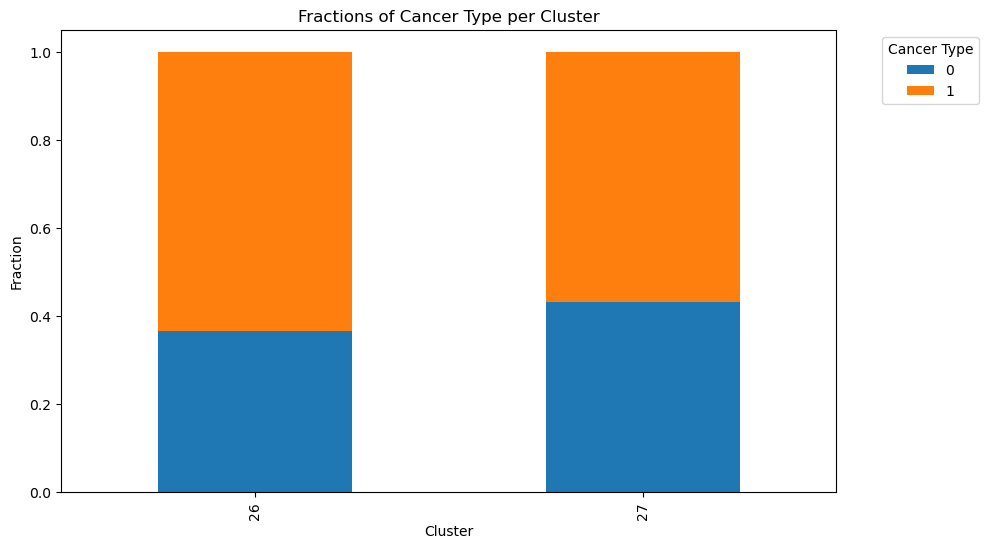

In [35]:
# Quick and dirty plots to visualize difference in clincial information ebtween cluster 26 and 26 
# Count the occurrences of each cancer type per cluster
# Adjust the index
count_df = df_plots.groupby(['cluster',  pi.columns[1]]).size().unstack(fill_value=0)

# Calculate the fraction of each cancer type per cluster
fraction_df = count_df.div(count_df.sum(axis=1), axis=0)

# Plotting the stacked bar chart
fraction_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Fractions of Cancer Type per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fraction')
plt.legend(title='Cancer Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [5]:
df = pd.merge(df, pi[['Patient_ID', 'death', 'survival']], on='Patient_ID', how='inner')

df

,Patient_ID,source_ID,source_cluster,Alt.MAC,B,Cancer,Cl_Mac,Cl_Mo,DC,Endothelial,...,Unknown,agglomerateto_275,agglomerateto_19,cluster,agglomerateto_48,surv_5y,Location_Center_X,Location_Center_Y,death,survival
0,LUAD_D001,D001_0,Cancer,0.166667,0.0,0.166667,0.166667,0.0,0.0,0.000000,...,0.000000,1,7,27,27,1,93,159,1,8.386
1,LUAD_D001,D001_1,Tc,0.000000,0.0,0.285714,0.000000,0.0,0.0,0.000000,...,0.428571,2,17,34,34,1,74,186,1,8.386
2,LUAD_D001,D001_10,Th,0.000000,0.0,0.363636,0.272727,0.0,0.0,0.000000,...,0.000000,3,1,5,47,1,120,149,1,8.386
3,LUAD_D001,D001_100,Cancer,0.000000,0.0,0.714286,0.000000,0.0,0.0,0.142857,...,0.142857,4,9,7,3,1,4,407,1,8.386
4,LUAD_D001,D001_1000,Treg,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.083333,...,0.333333,1,7,27,27,1,782,270,1,8.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637717,LUAD_D416,D416_995,Unknown,0.000000,0.0,0.166667,0.500000,0.0,0.0,0.000000,...,0.166667,44,1,39,39,1,275,835,0,9.386
1637718,LUAD_D416,D416_996,Cl_Mac,0.000000,0.0,0.400000,0.200000,0.0,0.0,0.000000,...,0.200000,72,1,6,2,1,110,858,0,9.386
1637719,LUAD_D416,D416_997,Cancer,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,...,0.333333,146,2,31,31,1,153,908,0,9.386
1637720,LUAD_D416,D416_998,Cl_Mac,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.000000,...,0.166667,1,7,27,27,1,155,842,0,9.386


In [30]:
vip_clus = 26
df_ct_prevalence = df.drop(columns=['source_ID', 'source_cluster', 'agglomerateto_275', 'agglomerateto_19', 'agglomerateto_48', 'surv_5y', 'Location_Center_X', 'Location_Center_Y'])
df_c26 = df_ct_prevalence[df_ct_prevalence['cluster'] == vip_clus].drop(columns=['cluster']).groupby('Patient_ID').mean().reset_index()

df_c26

,Patient_ID,Alt.MAC,B,Cancer,Cl_Mac,Cl_Mo,DC,Endothelial,Int_Mo,Mast,NK,Neutrophil,Non-Cl_Mo,T_other,Tc,Th,Treg,Unknown,death,survival
0,LUAD_D001,0.007568,0.066133,0.011675,0.072313,0.037763,0.000000,0.096685,0.001423,0.008019,0.000000,0.009817,0.008635,0.012710,0.140561,0.311811,0.074804,0.140081,1.0,8.386
1,LUAD_D002,0.019528,0.145750,0.018147,0.039524,0.016117,0.004256,0.076030,0.001508,0.005901,0.000000,0.005383,0.002169,0.001504,0.232593,0.385387,0.038276,0.007927,0.0,10.111
2,LUAD_D003,0.008447,0.249006,0.038655,0.056574,0.030680,0.006968,0.069140,0.000000,0.003672,0.007719,0.031867,0.005671,0.004264,0.041410,0.347286,0.034286,0.064355,1.0,2.094
3,LUAD_D004,0.016989,0.228551,0.019301,0.037716,0.048202,0.000000,0.150384,0.001350,0.001003,0.000000,0.000000,0.001593,0.031437,0.262615,0.156979,0.027912,0.015967,1.0,1.755
4,LUAD_D005,0.031885,0.340423,0.003923,0.029854,0.034243,0.003549,0.087657,0.000828,0.002756,0.001065,0.001242,0.001630,0.002435,0.129149,0.279676,0.022913,0.026773,1.0,7.598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,LUAD_D412,0.028509,0.058502,0.008833,0.120051,0.000000,0.000000,0.048392,0.000000,0.024269,0.000000,0.026417,0.012427,0.020282,0.061616,0.383709,0.005848,0.201145,0.0,9.944
402,LUAD_D413,0.008587,0.102076,0.030472,0.101315,0.001914,0.001650,0.042319,0.000000,0.013774,0.000000,0.012718,0.003910,0.017759,0.272221,0.330153,0.020624,0.040507,0.0,8.132
403,LUAD_D414,0.006518,0.206665,0.014442,0.036821,0.009979,0.000000,0.064522,0.000352,0.010719,0.001395,0.012083,0.000866,0.019735,0.138565,0.430576,0.022282,0.024480,0.0,8.550
404,LUAD_D415,0.011905,0.079762,0.011905,0.000000,0.032143,0.000000,0.239286,0.000000,0.000000,0.000000,0.072619,0.032143,0.000000,0.186905,0.195238,0.000000,0.138095,1.0,1.862


In [6]:
relevant = df_full[['Patient_ID', 'cluster', 'survival', 'death', 'relative_frequency']]
relevant[relevant['Patient_ID'] == 'LUAD_D001']
# relevant

,Patient_ID,cluster,survival,death,relative_frequency
0,LUAD_D001,1,8.386,1,0.012398
1,LUAD_D001,2,8.386,1,0.000664
2,LUAD_D001,3,8.386,1,0.002657
3,LUAD_D001,4,8.386,1,0.043834
4,LUAD_D001,5,8.386,1,0.305070
5,LUAD_D001,6,8.386,1,0.017932
6,LUAD_D001,7,8.386,1,0.077706
7,LUAD_D001,8,8.386,1,0.015940
8,LUAD_D001,9,8.386,1,0.016604
9,LUAD_D001,11,8.386,1,0.012840


In [47]:
df[df['cluster'] == 20]

,Patient_ID,source_ID,source_cluster,Alt.MAC,B,Cancer,Cl_Mac,Cl_Mo,DC,Endothelial,...,Unknown,agglomerateto_275,agglomerateto_19,cluster,agglomerateto_48,surv_5y,Location_Center_X,Location_Center_Y,death,survival
1499,LUAD_D001,D001_2347,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,1,573,855,1,8.386
1906,LUAD_D001,D001_2713,Cancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,1,799,974,1,8.386
20016,LUAD_D006,D006_1453,Cl_Mac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,1,644,493,1,5.246
20235,LUAD_D006,D006_1653,Cancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,1,714,547,1,5.246
48832,LUAD_D014,D014_1649,Cl_Mac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,0,712,567,1,4.876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632506,LUAD_D415,D415_152,Neutrophil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,0,48,488,1,1.862
1633107,LUAD_D415,D415_2066,Cl_Mac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,0,69,452,1,1.862
1633125,LUAD_D415,D415_2082,Neutrophil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,0,50,477,1,1.862
1633343,LUAD_D415,D415_2280,Cancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,20,20,0,272,896,1,1.862


In [44]:
df_full[df_full['cluster'] == 20][['Patient_ID', 'relative_frequency']].sort_values('relative_frequency')

,Patient_ID,relative_frequency
1075,LUAD_D038,0.000136
5413,LUAD_D177,0.000151
5739,LUAD_D188,0.000175
8257,LUAD_D271,0.000178
12206,LUAD_D396,0.000196
...,...,...
2822,LUAD_D096,0.047194
650,LUAD_D023,0.086604
2691,LUAD_D092,0.119333
10583,LUAD_D345,0.133350


Amount of people with 0 prevalence exactly: 0


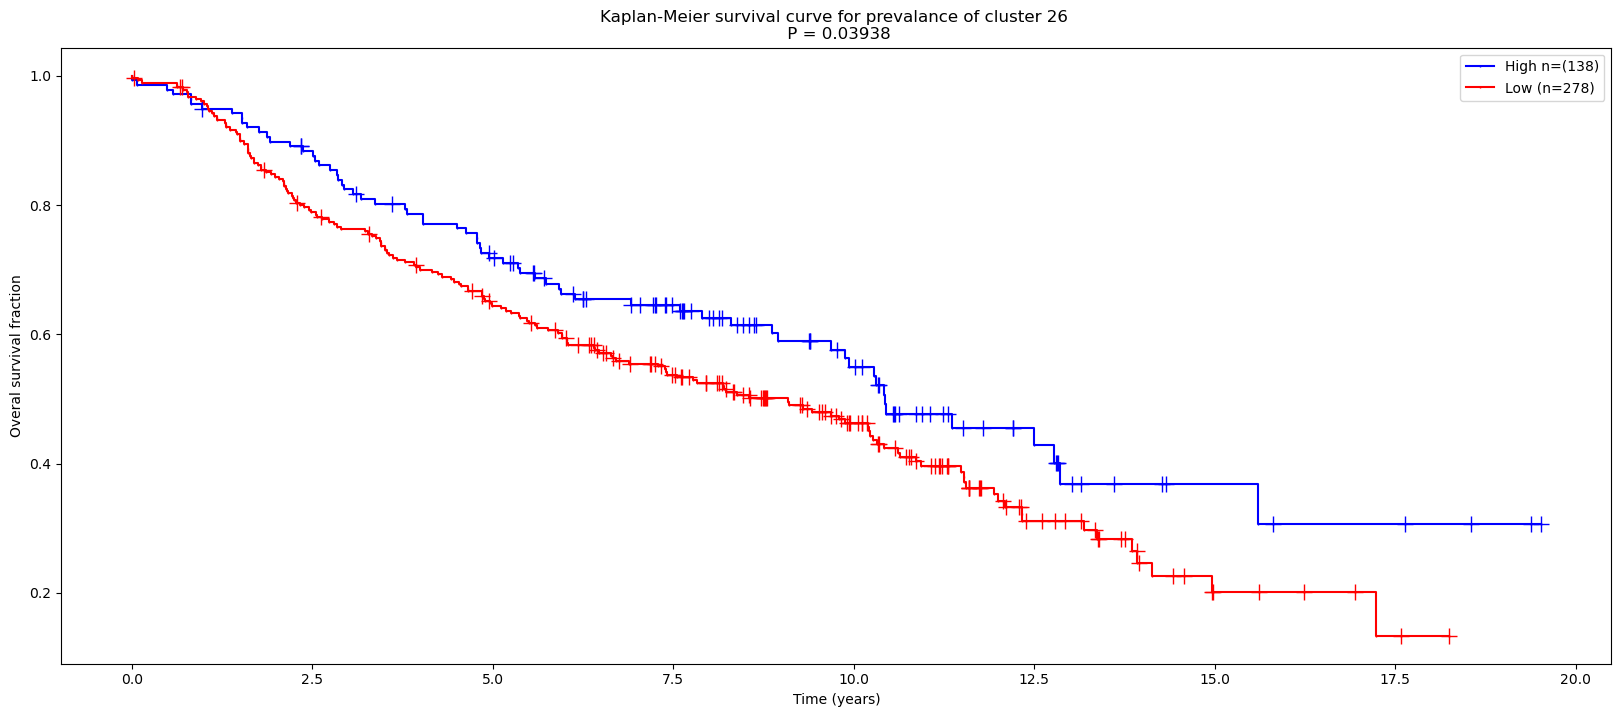

In [16]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# Log rank test 
p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 8))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster} \n P = {round(p_val, 5)}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.savefig(f'{data_path}/clustering_plots/KM_cluster{vip_cluster}.png', dpi=300)

plt.show()

Amount of people with 0 prevalence exactly: 0


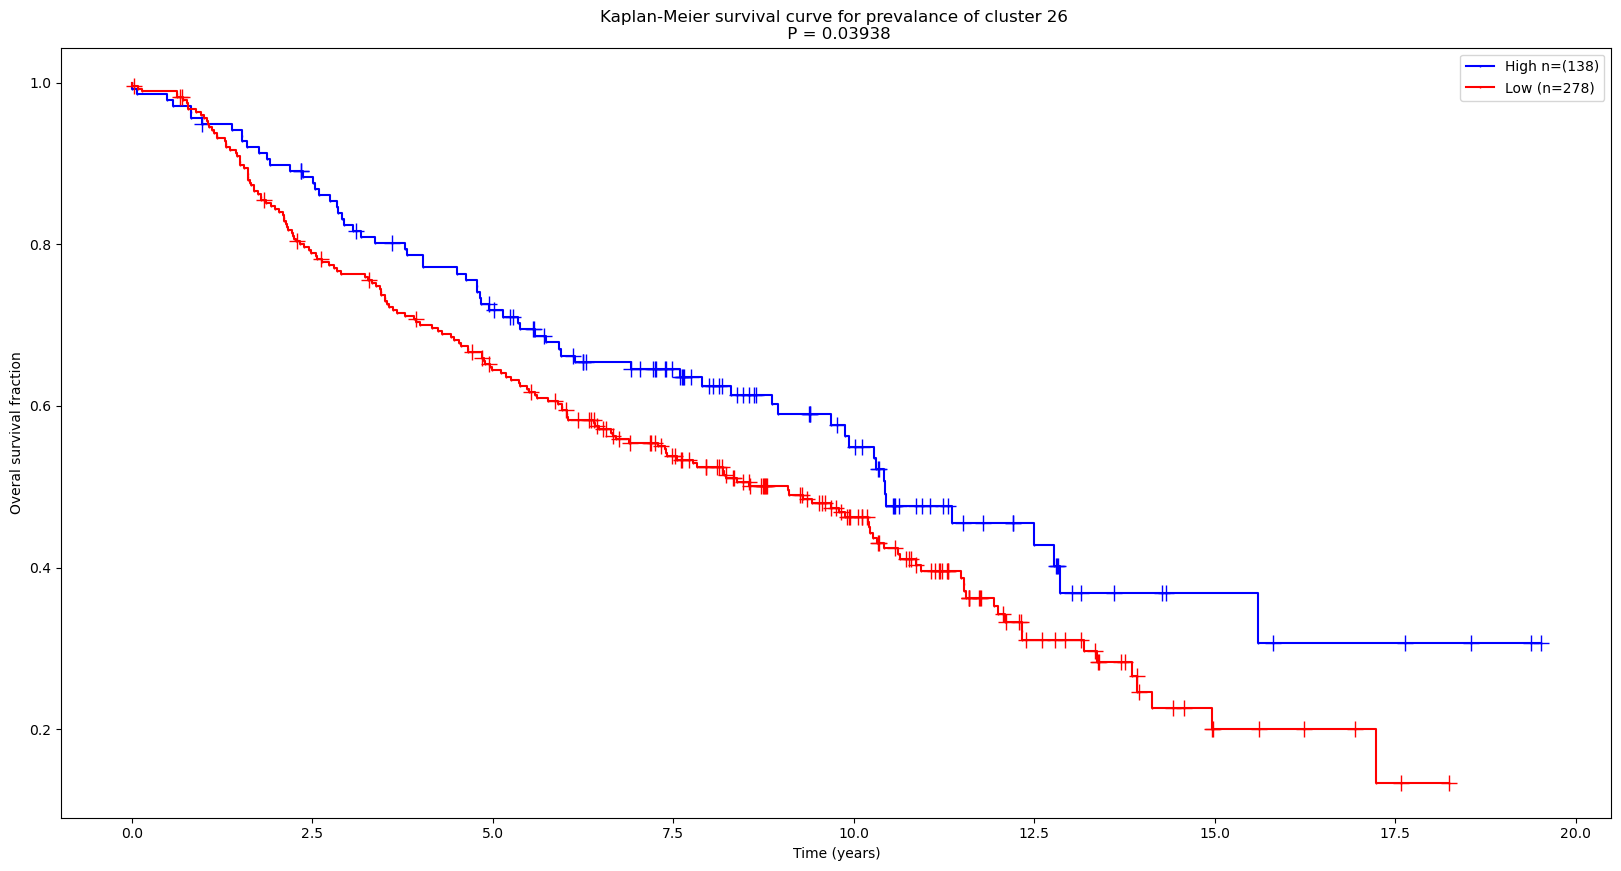

In [12]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# Log rank test 
p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 10))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()

plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster} \n P = {round(p_val, 5)}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.savefig(f'{data_path}/clustering_plots/KM_cluster{vip_cluster}.png', dpi=300)

plt.show()

In [ ]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# Log rank test 
p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 8))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster} \n P = {round(p_val, 5)}')


In [38]:
ax[7][2]

<Axes: >

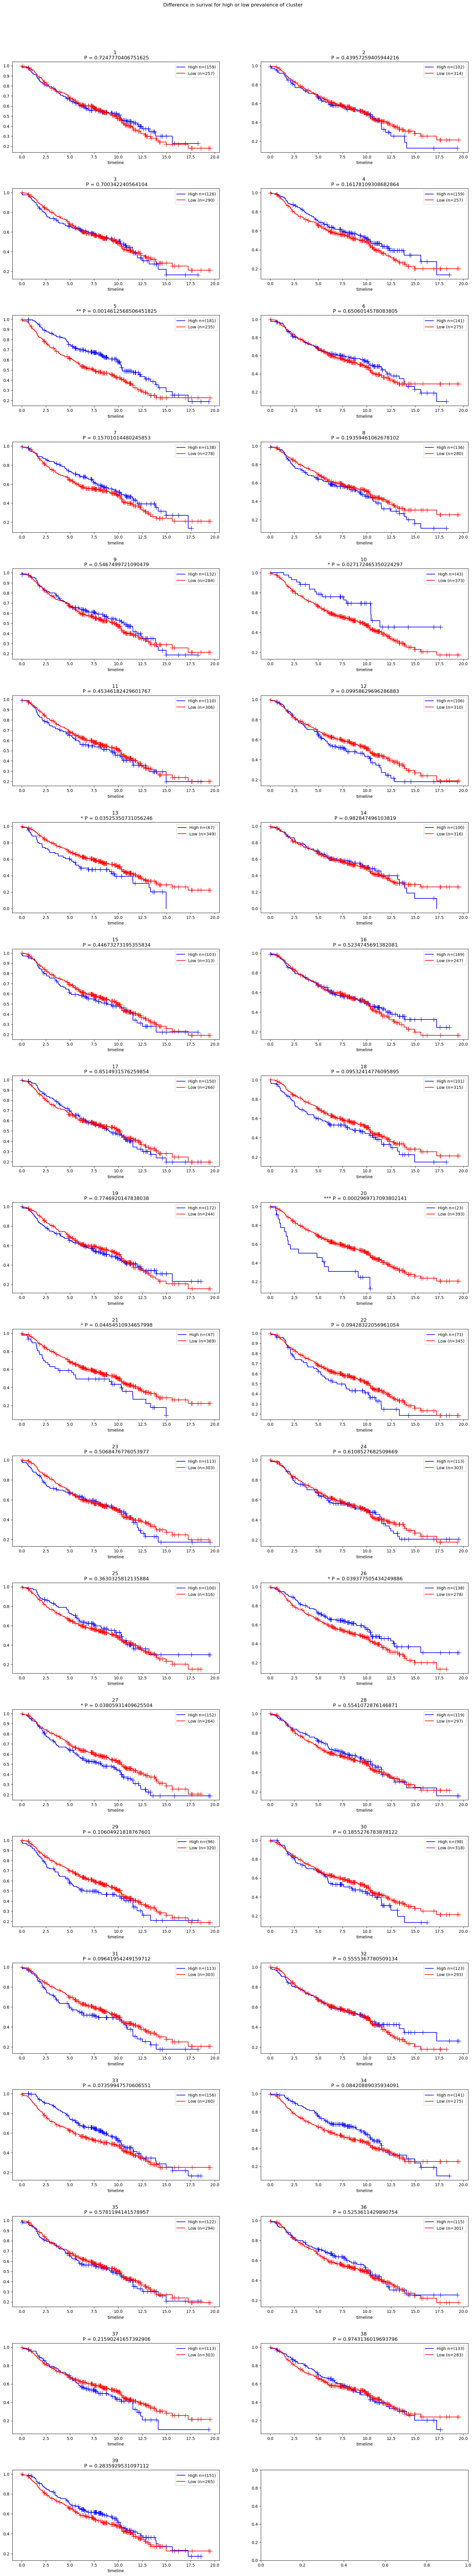

In [28]:
# Create subplots
fig, ax = plt.subplots(20, 2, figsize=(20, 40))
fig.set_figheight(100)

plt.subplots_adjust(hspace=0.4)  # Adjust vertical space between subplots


for vip_cluster in range(1, df_full['cluster'].max() + 1):


    patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
    patients_km.fillna(0, inplace=True)

    # Calculate the z-score for the 'agglomerateto40' column
    patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
    patients_km.reset_index('survival', inplace=True)

    # Sort the DataFrame by survival years in ascending order
    df_sorted_km = patients_km.sort_values(by='survival')

    # Filter the dataframe for patients with a z-score of 0 or higher
    patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
    patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

    p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

    # Create a KaplanMeierFitter object
    kmf = KaplanMeierFitter()

    # Fit the Kaplan-Meier curve to your data
    kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])
    # Plot the first curve
    kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=0.01, ax=ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2])

    kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
    kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=0.01, ax=ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2])
    
    if p_val < 0.001:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n *** P = {p_val}')
    elif p_val < 0.01:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n ** P = {p_val}')
    elif p_val < 0.05:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n * P = {p_val}')
    else:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n P = {p_val}')


    

fig.suptitle(f'Difference in survival for high or low prevalence of cluster')
plt.subplots_adjust(top=0.96)  # Adjust the top to make room for the title

plt.show()
    # print(vip_cluster, (vip_cluster - 1)//4,(vip_cluster - 1)% )
    # kmf.plot()
    # ax[(vip_cluster - 1)//4][(vip_cluster - 1)%4].set_title(f'Differenc in surival for high or low prevalence of cluster {vip_cluster}')
    # plt.legend(None)



